In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
# ===============================================================
# 🔰 Step 1 — Import Libraries
# ===============================================================
import numpy as np
import pandas as pd
import os, time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [7]:
# ===============================================================
# 🔰 Step 2 — Device Setup & Data Preparation
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Dataset path
DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"

# ✅ Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# ✅ Split 90:10 (Train:Test)
test_ratio = 0.1
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

# ✅ Split 10% of Train as Validation
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# ✅ Dataloader setup
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda
Train: 915, Test: 101
Train: 824, Validation: 91, Test: 101


In [8]:
# ===============================================================
# 🔰 Step 3 — Model: MobileNetV2
# ===============================================================
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# ✅ Load pretrained weights
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

# ✅ Replace final classifier layer
num_classes = len(dataset.classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# ✅ Move to device
model = model.to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [9]:
# ===============================================================
# 🔰 Step 4 — Train & Evaluate Functions
# ===============================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [10]:
# ===============================================================
# 🔰 Step 5 — Training Loop
# ===============================================================
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0.0

start_time = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mobilenetv2_model.pth")

end_time = time.time()
print(f"\n✅ Total training time: {end_time - start_time:.2f} sec")



Epoch 1/50


Train Loss: 2.2795, Acc: 0.2124 | Val Loss: 2.0983, Acc: 0.3407

Epoch 2/50


Train Loss: 1.8847, Acc: 0.5231 | Val Loss: 1.7748, Acc: 0.4505

Epoch 3/50


Train Loss: 1.4997, Acc: 0.5995 | Val Loss: 1.4660, Acc: 0.5604

Epoch 4/50


Train Loss: 1.1592, Acc: 0.7354 | Val Loss: 1.2086, Acc: 0.6154

Epoch 5/50


Train Loss: 0.8594, Acc: 0.8289 | Val Loss: 0.9928, Acc: 0.6923

Epoch 6/50


Train Loss: 0.6339, Acc: 0.8738 | Val Loss: 0.8489, Acc: 0.7253

Epoch 7/50


Train Loss: 0.4348, Acc: 0.9248 | Val Loss: 0.7523, Acc: 0.7473

Epoch 8/50


Train Loss: 0.3063, Acc: 0.9417 | Val Loss: 0.6876, Acc: 0.7802

Epoch 9/50


Train Loss: 0.1977, Acc: 0.9757 | Val Loss: 0.6545, Acc: 0.7692

Epoch 10/50


Train Loss: 0.1485, Acc: 0.9818 | Val Loss: 0.6412, Acc: 0.7692

Epoch 11/50


Train Loss: 0.1112, Acc: 0.9867 | Val Loss: 0.5988, Acc: 0.7912

Epoch 12/50


Train Loss: 0.0879, Acc: 0.9879 | Val Loss: 0.6266, Acc: 0.7912

Epoch 13/50


Train Loss: 0.0777, Acc: 0.9867 | Val Loss: 0.6606, Acc: 0.7802

Epoch 14/50


Train Loss: 0.0602, Acc: 0.9891 | Val Loss: 0.6488, Acc: 0.7912

Epoch 15/50


Train Loss: 0.0484, Acc: 0.9927 | Val Loss: 0.6486, Acc: 0.7802

Epoch 16/50


Train Loss: 0.0461, Acc: 0.9927 | Val Loss: 0.6509, Acc: 0.8022

Epoch 17/50


Train Loss: 0.0366, Acc: 0.9927 | Val Loss: 0.6569, Acc: 0.8022

Epoch 18/50


Train Loss: 0.0341, Acc: 0.9939 | Val Loss: 0.6113, Acc: 0.8132

Epoch 19/50


Train Loss: 0.0323, Acc: 0.9951 | Val Loss: 0.6628, Acc: 0.7582

Epoch 20/50


Train Loss: 0.0288, Acc: 0.9976 | Val Loss: 0.6503, Acc: 0.7912

Epoch 21/50


Train Loss: 0.0251, Acc: 0.9976 | Val Loss: 0.6680, Acc: 0.7912

Epoch 22/50


Train Loss: 0.0219, Acc: 0.9976 | Val Loss: 0.6415, Acc: 0.7912

Epoch 23/50


Train Loss: 0.0207, Acc: 0.9988 | Val Loss: 0.6532, Acc: 0.8132

Epoch 24/50


Train Loss: 0.0162, Acc: 0.9988 | Val Loss: 0.6264, Acc: 0.8242

Epoch 25/50


Train Loss: 0.0179, Acc: 1.0000 | Val Loss: 0.6764, Acc: 0.7912

Epoch 26/50


Train Loss: 0.0139, Acc: 0.9988 | Val Loss: 0.6761, Acc: 0.7912

Epoch 27/50


Train Loss: 0.0149, Acc: 1.0000 | Val Loss: 0.6681, Acc: 0.8132

Epoch 28/50


Train Loss: 0.0111, Acc: 1.0000 | Val Loss: 0.6289, Acc: 0.8132

Epoch 29/50


Train Loss: 0.0096, Acc: 0.9988 | Val Loss: 0.6750, Acc: 0.8132

Epoch 30/50


Train Loss: 0.0098, Acc: 1.0000 | Val Loss: 0.6740, Acc: 0.8132

Epoch 31/50


Train Loss: 0.0099, Acc: 1.0000 | Val Loss: 0.6966, Acc: 0.8022

Epoch 32/50


Train Loss: 0.0092, Acc: 1.0000 | Val Loss: 0.6888, Acc: 0.7912

Epoch 33/50


Train Loss: 0.0112, Acc: 1.0000 | Val Loss: 0.7065, Acc: 0.7912

Epoch 34/50


Train Loss: 0.0065, Acc: 1.0000 | Val Loss: 0.7205, Acc: 0.8022

Epoch 35/50


Train Loss: 0.0069, Acc: 1.0000 | Val Loss: 0.7492, Acc: 0.7802

Epoch 36/50


Train Loss: 0.0062, Acc: 1.0000 | Val Loss: 0.7208, Acc: 0.7912

Epoch 37/50


Train Loss: 0.0046, Acc: 1.0000 | Val Loss: 0.7340, Acc: 0.7802

Epoch 38/50


Train Loss: 0.0052, Acc: 1.0000 | Val Loss: 0.7246, Acc: 0.7802

Epoch 39/50


Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.8878, Acc: 0.7692

Epoch 40/50


Train Loss: 0.0200, Acc: 0.9976 | Val Loss: 0.8211, Acc: 0.7582

Epoch 41/50


Train Loss: 0.0099, Acc: 1.0000 | Val Loss: 0.7550, Acc: 0.8132

Epoch 42/50


Train Loss: 0.0068, Acc: 0.9988 | Val Loss: 0.7754, Acc: 0.8022

Epoch 43/50


Train Loss: 0.0127, Acc: 0.9976 | Val Loss: 0.8165, Acc: 0.7912

Epoch 44/50


Train Loss: 0.0122, Acc: 0.9988 | Val Loss: 0.8226, Acc: 0.7692

Epoch 45/50


Train Loss: 0.0204, Acc: 0.9939 | Val Loss: 0.8107, Acc: 0.8022

Epoch 46/50


Train Loss: 0.0194, Acc: 0.9951 | Val Loss: 0.9016, Acc: 0.7912

Epoch 47/50


Train Loss: 0.0164, Acc: 0.9951 | Val Loss: 0.7906, Acc: 0.7802

Epoch 48/50


Train Loss: 0.0114, Acc: 0.9988 | Val Loss: 0.7186, Acc: 0.7912

Epoch 49/50


Train Loss: 0.0053, Acc: 1.0000 | Val Loss: 0.7149, Acc: 0.7912

Epoch 50/50


Train Loss: 0.0059, Acc: 0.9988 | Val Loss: 0.7559, Acc: 0.7692

✅ Total training time: 933.22 sec


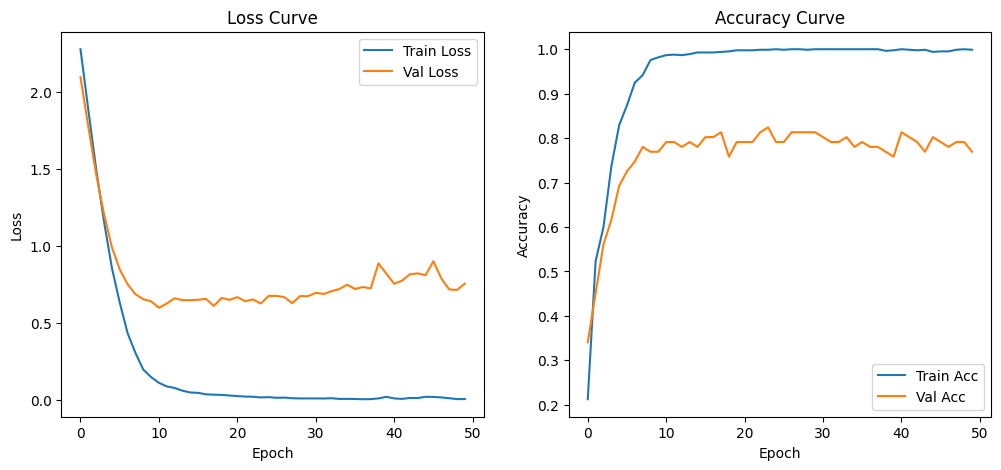

In [11]:
# ===============================================================
# 🔰 Step 6 — Plot Loss & Accuracy Curves
# ===============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [12]:
# ===============================================================
# 🔰 Step 7 — Test Evaluation
# ===============================================================
model.load_state_dict(torch.load("best_mobilenetv2_model.pth"))
test_start = time.time()
test_loss, test_acc, all_preds, all_labels, all_probs = evaluate(model, test_loader, criterion)
test_end = time.time()

print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test time: {test_end - test_start:.2f} sec")



✅ Test Accuracy: 73.27%
✅ Test time: 2.65 sec



Classification Report:
                       precision    recall  f1-score   support

  Genus Criconemoides     0.9412    0.8889    0.9143        18
Genus Helicotylenchus     0.9167    0.9167    0.9167        12
Genus Hemicycliophora     0.0000    0.0000    0.0000         2
 Genus Hirschmaniella     0.3889    0.5833    0.4667        12
    Genus Hoplolaimus     0.9231    0.9231    0.9231        13
    Genus Meloidogyne     0.8750    0.5600    0.6829        25
   Genus Pratylenchus     0.3333    1.0000    0.5000         5
     Genus Radopholus     1.0000    0.3333    0.5000         3
    Genus Trichodorus     1.0000    1.0000    1.0000         4
      Genus Xiphinema     0.8000    0.5714    0.6667         7

             accuracy                         0.7327       101
            macro avg     0.7178    0.6777    0.6570       101
         weighted avg     0.7995    0.7327    0.7406       101



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


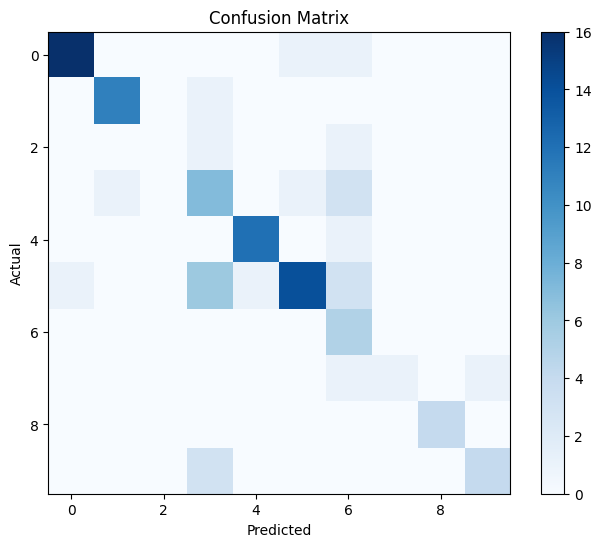


Per-class Accuracy:
Genus Criconemoides: 88.89%
Genus Helicotylenchus: 91.67%
Genus Hemicycliophora: 0.00%
Genus Hirschmaniella: 58.33%
Genus Hoplolaimus: 92.31%
Genus Meloidogyne: 56.00%
Genus Pratylenchus: 100.00%
Genus Radopholus: 33.33%
Genus Trichodorus: 100.00%
Genus Xiphinema: 57.14%


In [13]:
# ===============================================================
# 🔰 Step 8 — Classification Report & Confusion Matrix
# ===============================================================
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

unique_labels = sorted(list(set(all_labels)))
target_names = [dataset.classes[i] for i in unique_labels]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, label_idx in enumerate(unique_labels):
    cls_name = dataset.classes[label_idx]
    print(f"{cls_name}: {per_class_acc[i]*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


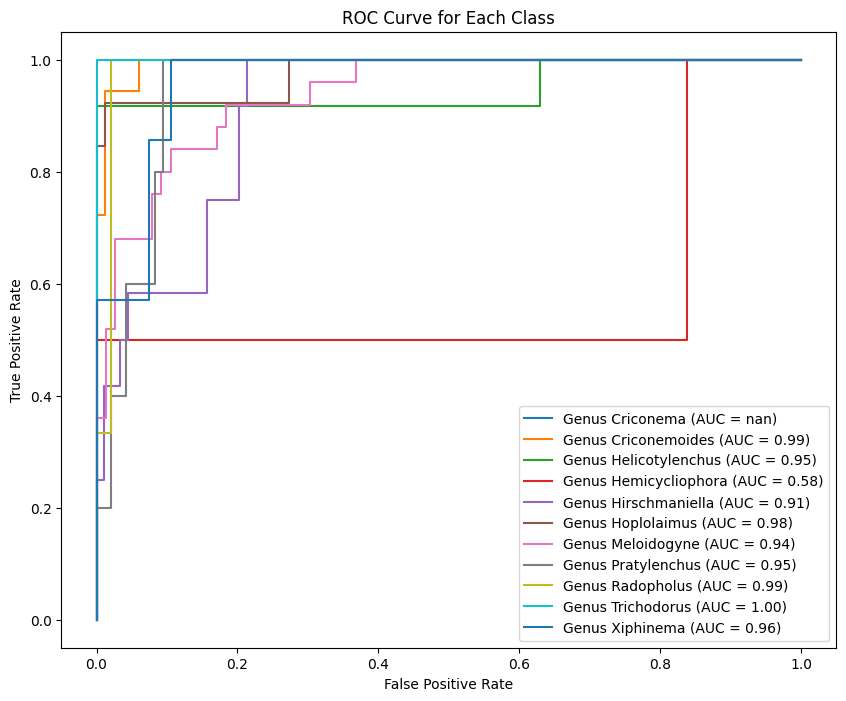

In [14]:
# ===============================================================
# 🔰 Step 9 — ROC Curve for Each Class
# ===============================================================
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

plt.figure(figsize=(10, 8))
for i, cls in enumerate(dataset.classes):
    binary_labels = (all_labels == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend()
plt.show()


In [15]:
# ===============================================================
# 🔰 Step 10 — GFLOPs and Parameter Count
# ===============================================================
!pip install thop -q

from thop import profile

# Create a dummy input for 224x224 RGB image
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Profile the model
flops, params = profile(model, inputs=(dummy_input, ))

print(f"\n⚙️ Model Complexity Report:")
print(f"Total Parameters: {params/1e6:.2f} Million")
print(f"Total GFLOPs: {flops/1e9:.2f}")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.

⚙️ Model Complexity Report:
Total Parameters: 2.24 Million
Total GFLOPs: 0.33
